In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
import xarray as xr
import xmitgcm
import cmocean
import sys
import os

import time
from matplotlib.colors import LogNorm

from IPython.display import clear_output
# import xgcm
import xrft

from dask.array import ones_like


from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap



/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [13]:
plt.rcParams.update({'font.size': 16
    , 'legend.markerscale': 1., 'axes.titlesize': 20, 'axes.labelsize' : 12,
      'legend.fontsize' : 14,'legend.handlelength': 3})

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

colors = [color1, color2, color4, color3]
plt.rcParams.update({'figure.figsize' : (15,5)})
plt.rcParams.update({
    "text.usetex": True,
   })

In [3]:
dir_grid = ['/central/groups/oceanphysics/anirban/grid_uniform/grid_2km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_4km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_8km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_16km/',
            
            ]


dirroot_s = '/central/groups/oceanphysics/anirban/smalldomain_4h/'


res = ['2km','4km','8km','16km']
deltaT = [80,200,200,300]

xs1 = [720,360,180,90]
xs2 = [1120,560,280,140]
ys1 = [120,60,30,15]
ys2 = [480,240,120,60]


zlevels = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9.,10.,11.,12.,13.,14.,15.,
                    16.,17.,18.,19.,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,
                    31.,32.,33.,34.,35.,36.,37.,38.,39.,40.,41.,42.,43.,44.,45.,
                    46.,47.,48.,49.,50.,51.,52.,53.,54.,55.,56.,57.,58.,])
zlevels = (zlevels -1).astype(int)


grids = {}
grids2 = {}

for it, r in enumerate(res):
    grids[r] = xmitgcm.open_mdsdataset(dir_grid[it], delta_t=deltaT[it],
                                       ref_date="2008-01-01 00:00:00", iters = None)


    grids2[r] = grids[r].isel(XC=slice(xs1[it], xs2[it]),XG=slice(xs1[it], xs2[it]),
                           YC=slice(ys1[it], ys2[it]),YG=slice(ys1[it], ys2[it]),
                           Z = zlevels, Zl = zlevels, Zu = zlevels, Zp1 = zlevels,).drop(['Zp1'])


/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2+89.g4a9c748-py3.6.egg/xmitgcm/mds_store.py:887: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/ or /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2+89.g4a9c748-py3.6.egg/xmitgcm/mds_store.py:887: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/ or /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2+89.g4a9c748-py3.6.egg/xmitgcm/mds_store.py:887: U

In [4]:
%%time
ds_b = {}
ds_spec = {}
ds_PEb = {}
for r in res:
    ds_b[r] = xr.open_dataset(dirroot_s+'%s_timeseries_b_wg.nc' %r)
    ds_spec[r] = xr.open_mfdataset(dirroot_s+'%s_cospectra_monthly_m*.nc' %r)
    ds_PEb[r] = xr.open_dataset(dirroot_s+'%s_areamean_PEbudget_revised2.nc' %r)

CPU times: user 2.64 s, sys: 1.15 s, total: 3.79 s
Wall time: 6.64 s


In [5]:
labels = {'2km': r'$\mathrm{2~km}$', '4km': r'$\mathrm{4~km}$', '8km': r'$\mathrm{8~km}$', '16km': r'$\mathrm{16~km}$', }
figdir = 'figs_paper_Mar/'

In [6]:
%%time
Nsq0 = {}
wphbph = {}
for r in res:
    wphbph[r] = ds_spec[r].wphbph.mean(dim='time').load()
    Nsq0[r] = -ds_b[r].b_z.mean(dim='time')

CPU times: user 279 ms, sys: 128 ms, total: 407 ms
Wall time: 407 ms


In [7]:
for r in res:
    ds_PEb[r]['P12'] = ds_PEb[r]['Udotgradbp2'] + ds_PEb[r]['Upbpdotgradb']
    ds_PEb[r]['P3'] = ds_PEb[r]['wpbp']*Nsq0[r] + ds_PEb[r]['wpbpbtilde_z']
    ds_PEb[r]['P123'] = ds_PEb[r]['Udotgradbp2'] + ds_PEb[r]['Upbpdotgradb'] + ds_PEb[r]['wpbp']*Nsq0[r] + ds_PEb[r]['wpbpbtilde_z']


In [8]:
def calc_mean_std_from_timeseries(ts):
    varlist = ['wpbp','Upbpdotgradb','Udotgradbp2','wpbpbtilde_z','P12','P3','P123']
    
    mstd = xr.merge([xr.merge([ts[v].std(dim='time').to_dataset(name=v+'_s') for v in varlist]) , 
                         xr.merge([ts[v].mean(dim='time').to_dataset(name=v+'_m') for v in varlist])])
    return mstd

In [9]:
labels = {'2km': r'$\mathrm{2~km}$', '4km': r'$\mathrm{4~km}$', '8km': r'$\mathrm{8~km}$', '16km': r'$\mathrm{16~km}$', }
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}

In [10]:
mean_std = {}
for r in res:
    mean_std[r] = calc_mean_std_from_timeseries(ds_PEb[r])

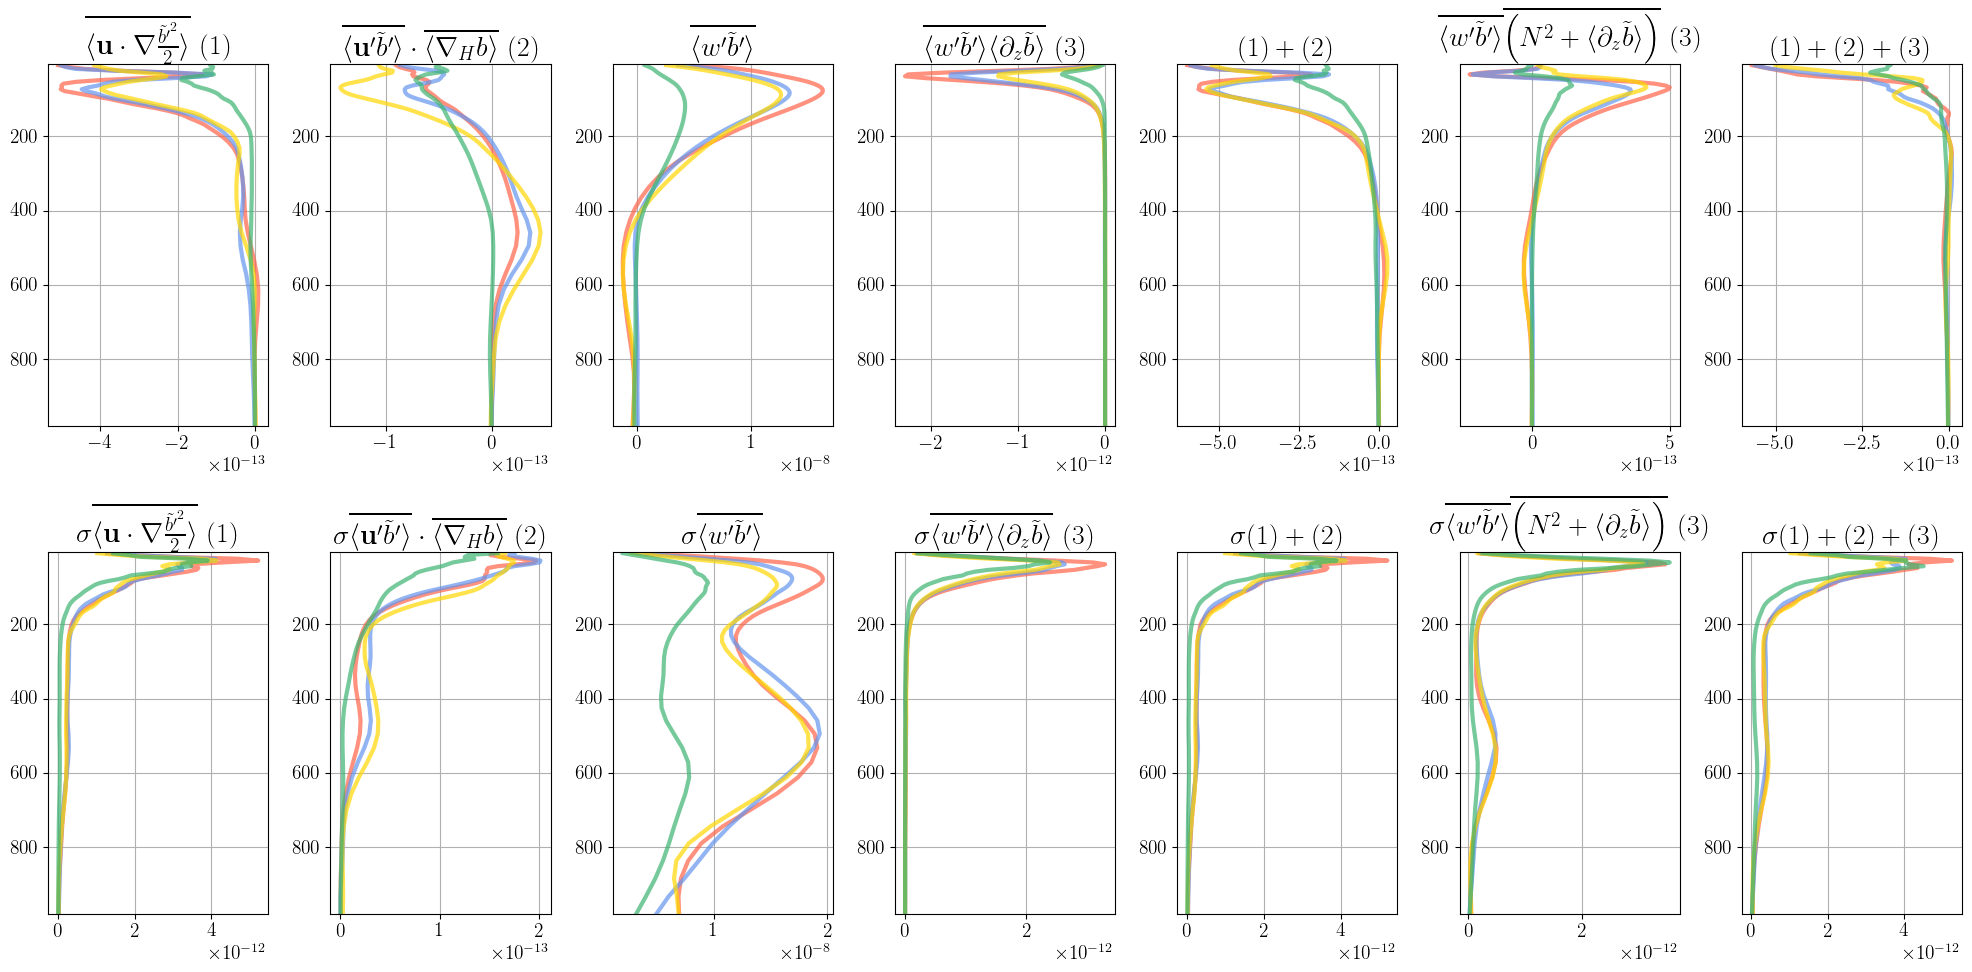

In [14]:
titles = [r"$\overline{\langle \mathbf{u} \cdot \nabla \frac{\tilde {b'}^2}{2} \rangle} $  $\mathrm{(1)}$", 
          r"$\overline{\langle \mathbf{u}' {\tilde b'} \rangle} \cdot \overline{\langle \nabla_H b \rangle}$  $\mathrm{(2)}$", 
          r"$\overline{\langle w' {\tilde b'} \rangle}$ ", 
          r"$\overline{\langle w' {\tilde b'} \rangle} \overline{\langle \partial_z \tilde b \rangle }$  $\mathrm{(3)}$", 
          r"$\mathrm{(1)+(2)}$", 
          r"$\overline{\langle w' {\tilde b'} \rangle} \overline{\left( N^2 + \langle \partial_z \tilde b \rangle \right)}$  $\mathrm{(3)}$", 
          r"$\mathrm{(1)+(2)+(3)}$",          
         ]
fig = plt.figure(figsize=(20,10), dpi=100, tight_layout=True)
for i, vr in enumerate(['Udotgradbp2','Upbpdotgradb','wpbp','wpbpbtilde_z','P12','P3','P123']):
    plt.subplot(2,7,i+1)
    for r in res:
        plt.plot(((mean_std[r][vr+'_m'])).sel(Z=slice(-5,-1000)), mean_std['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r], alpha=0.7)
    plt.ylim([-980,-5])
#     plt.xlim([-6.5e-13,6.5e-13])
    plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'])
    plt.ylabel('')
    plt.xlabel('')
    plt.title(titles[i], fontsize=20)
#     plt.legend(fontsize=12, loc=0, framealpha=0.5)
    plt.grid()
    plt.subplot(2,7,i+8)
    for r in res:
        plt.plot(((mean_std[r][vr+'_s'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r], alpha=0.7)
    plt.ylim([-980,-5])
#     plt.xlim([-6.5e-13,6.5e-13])
    plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'])
    plt.ylabel('')
    plt.xlabel('')
    plt.title(r"$\sigma$"+ titles[i], fontsize=20)
#     plt.legend(fontsize=12, loc=0, framealpha=0.5)
    plt.grid()

In [15]:
ds_PEb_daily = {}
for r in res:
    ds_PEb_daily[r] = ds_PEb[r].resample(time="D").mean()

In [16]:
mean_std = {}
for r in res:
    mean_std[r] = calc_mean_std_from_timeseries(ds_PEb_daily[r])

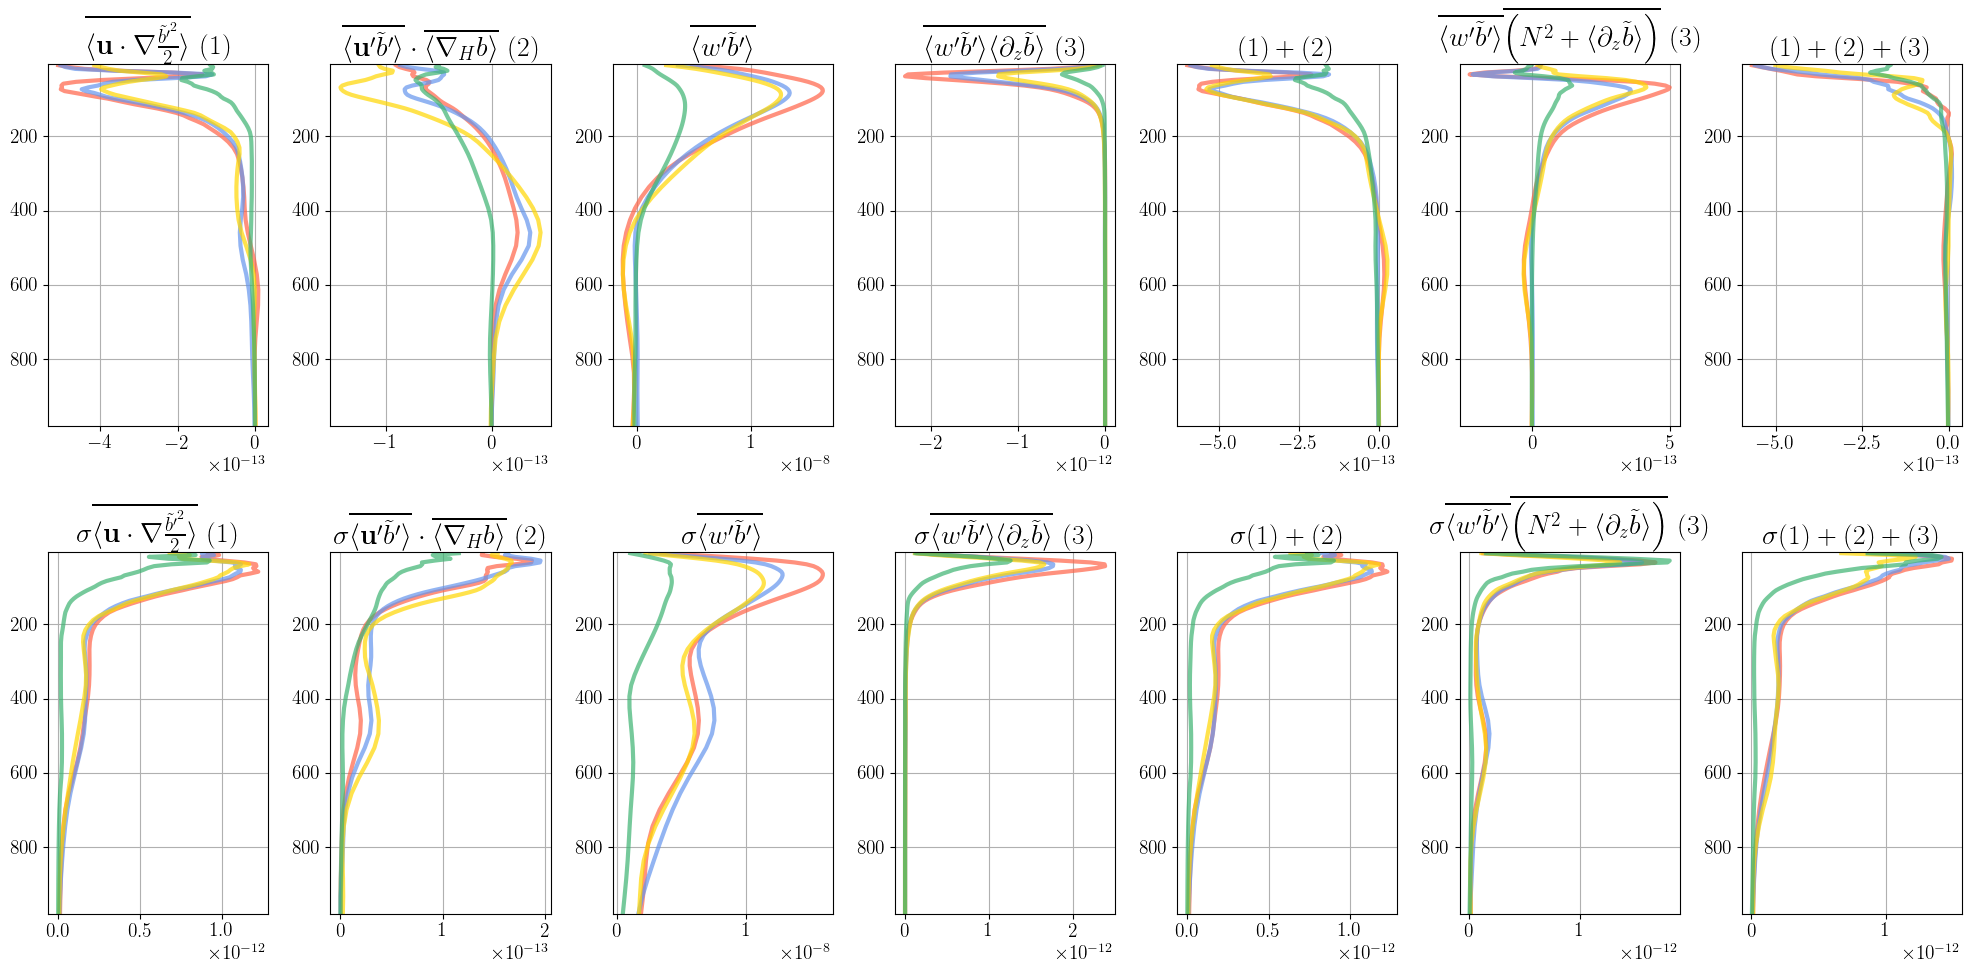

In [17]:
titles = [r"$\overline{\langle \mathbf{u} \cdot \nabla \frac{\tilde {b'}^2}{2} \rangle} $  $\mathrm{(1)}$", 
          r"$\overline{\langle \mathbf{u}' {\tilde b'} \rangle} \cdot \overline{\langle \nabla_H b \rangle}$  $\mathrm{(2)}$", 
          r"$\overline{\langle w' {\tilde b'} \rangle}$ ", 
          r"$\overline{\langle w' {\tilde b'} \rangle} \overline{\langle \partial_z \tilde b \rangle }$  $\mathrm{(3)}$", 
          r"$\mathrm{(1)+(2)}$", 
          r"$\overline{\langle w' {\tilde b'} \rangle} \overline{\left( N^2 + \langle \partial_z \tilde b \rangle \right)}$  $\mathrm{(3)}$", 
          r"$\mathrm{(1)+(2)+(3)}$",          
         ]
fig = plt.figure(figsize=(20,10), dpi=100, tight_layout=True)
for i, vr in enumerate(['Udotgradbp2','Upbpdotgradb','wpbp','wpbpbtilde_z','P12','P3','P123']):
    plt.subplot(2,7,i+1)
    for r in res:
        plt.plot(((mean_std[r][vr+'_m'])).sel(Z=slice(-5,-1000)), mean_std['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r], alpha=0.7)
    plt.ylim([-980,-5])
#     plt.xlim([-6.5e-13,6.5e-13])
    plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'])
    plt.ylabel('')
    plt.xlabel('')
    plt.title(titles[i], fontsize=20)
#     plt.legend(fontsize=12, loc=0, framealpha=0.5)
    plt.grid()
    plt.subplot(2,7,i+8)
    for r in res:
        plt.plot(((mean_std[r][vr+'_s'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r], alpha=0.7)
    plt.ylim([-980,-5])
#     plt.xlim([-6.5e-13,6.5e-13])
    plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'])
    plt.ylabel('')
    plt.xlabel('')
    plt.title(r"$\sigma$"+ titles[i], fontsize=20)
#     plt.legend(fontsize=12, loc=0, framealpha=0.5)
    plt.grid()

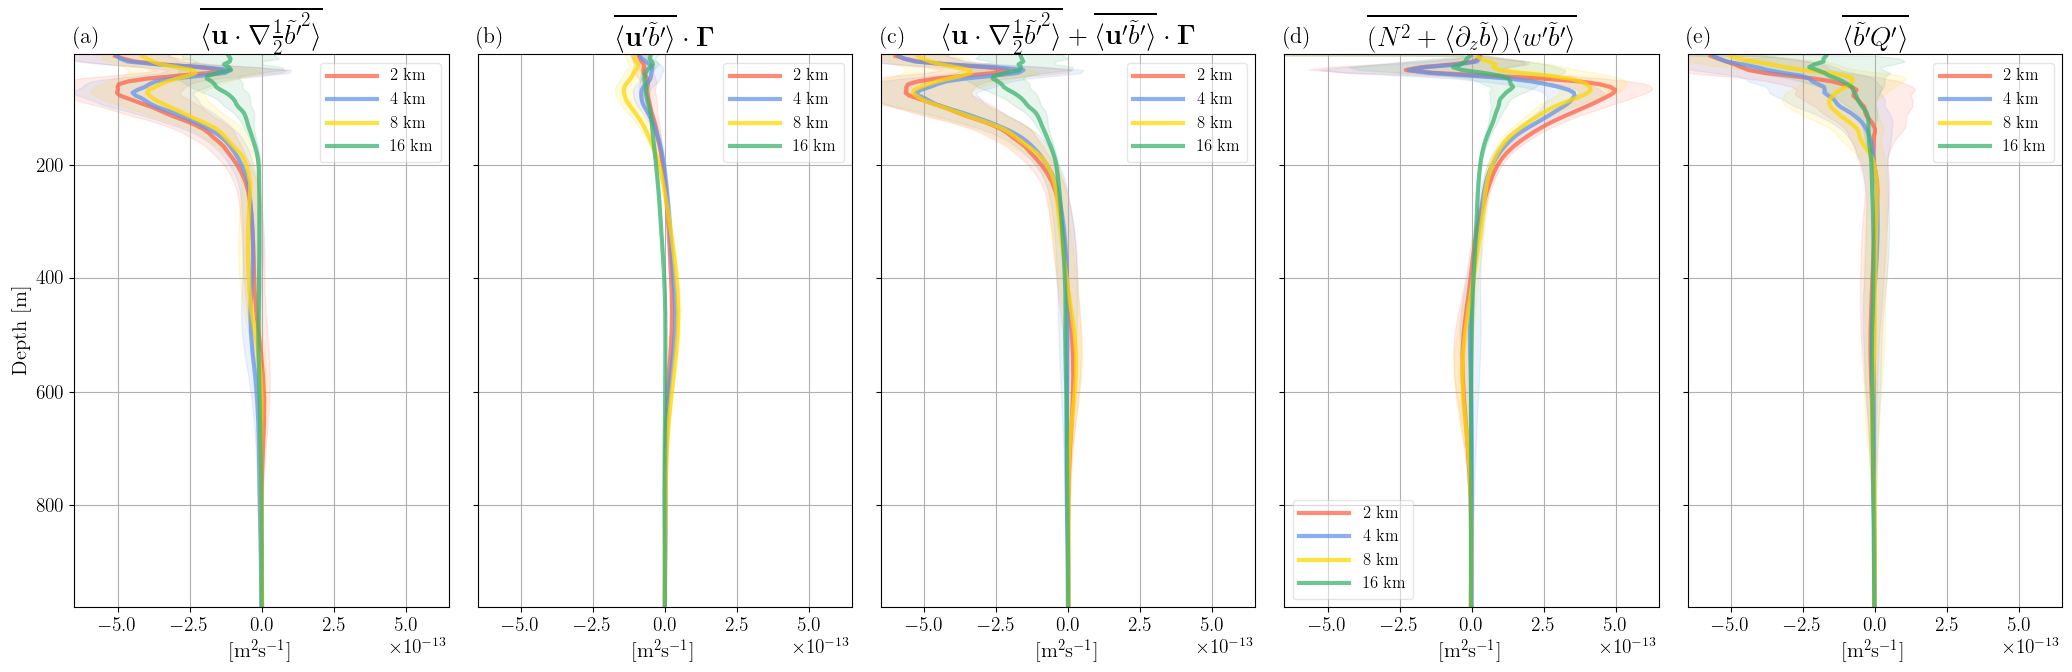

In [54]:
terms = ['wpbp', 'wpbpbtilde_z','Upbpdotgradb',
         'Udotgradbp2', 'Udotgradbp2_h']

titles = [r"$\overline{\langle {\mathbf u} \cdot \nabla \frac{1}{2} \tilde {b'}^2 \rangle} $", 
          r"$\overline{\langle \mathbf{u}' {\tilde b'} \rangle} \cdot \mathbf{\Gamma}$  ", 
          r"$\overline{\langle \mathbf{u} \cdot \nabla \frac{1}{2} \tilde {b'}^2 \rangle} + \overline{\langle \mathbf{u}' {\tilde b'} \rangle} \cdot \mathbf{\Gamma} $", 
          r"$\overline{( N^2 + \langle \partial_z \tilde b \rangle ) \langle w' {\tilde b'} \rangle} $ ", 
          r"$\overline{\langle \tilde {b'} Q' \rangle }$",          
         ]
axtexts = [r'$\mathrm{(a)}$',r'$\mathrm{(b)}$',r'$\mathrm{(c)}$',r'$\mathrm{(d)}$',r'$\mathrm{(e)}$']

fig = plt.figure(figsize=(21,7), dpi=100, tight_layout=True)

plt.subplot(1,5,1)
for r in res:
    plt.plot(((mean_std[r]['Udotgradbp2_m'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].Udotgradbp2_m+mean_std[r].Udotgradbp2_s/(5), 
                      mean_std[r].Udotgradbp2_m-mean_std[r].Udotgradbp2_s/(5), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'])
plt.ylabel(r'$\mathrm{Depth}$ $[\mathrm{m}]$', fontsize=15)
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[0], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[0]);

plt.subplot(1,5,2)
for r in res:
    plt.plot(((mean_std[r]['Upbpdotgradb_m'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].Upbpdotgradb_m+mean_std[r].Upbpdotgradb_s/(5), 
                      mean_std[r].Upbpdotgradb_m-mean_std[r].Upbpdotgradb_s/(5), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [])
plt.ylabel('')
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[1], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[1]);

plt.subplot(1,5,3)
for r in res:
    plt.plot(((mean_std[r]['P12_m'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].P12_m+mean_std[r].P12_s/(5), 
                      mean_std[r].P12_m-mean_std[r].P12_s/(5), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [])
plt.ylabel('')
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[2], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[2]);

plt.subplot(1,5,4)
for r in res:
    plt.plot(((mean_std[r]['P3_m'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].P3_m+mean_std[r].P3_s/(5), 
                      mean_std[r].P3_m-mean_std[r].P3_s/(5), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [])
plt.ylabel('')
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[3], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[3]);

plt.subplot(1,5,5)
for r in res:
    plt.plot(((mean_std[r]['P123_m'])).sel(Z=slice(-5,-1000)), 
             mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].P123_m+mean_std[r].P123_s/(5), 
                      mean_std[r].P123_m-mean_std[r].P123_s/(5), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [])
plt.ylabel('')
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[4], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[4]);
fig.savefig(figdir + 'PE_budget_terms_unnormalized')
fig.savefig(figdir + 'PE_budget_terms_unnormalized.pdf', dpi=200)

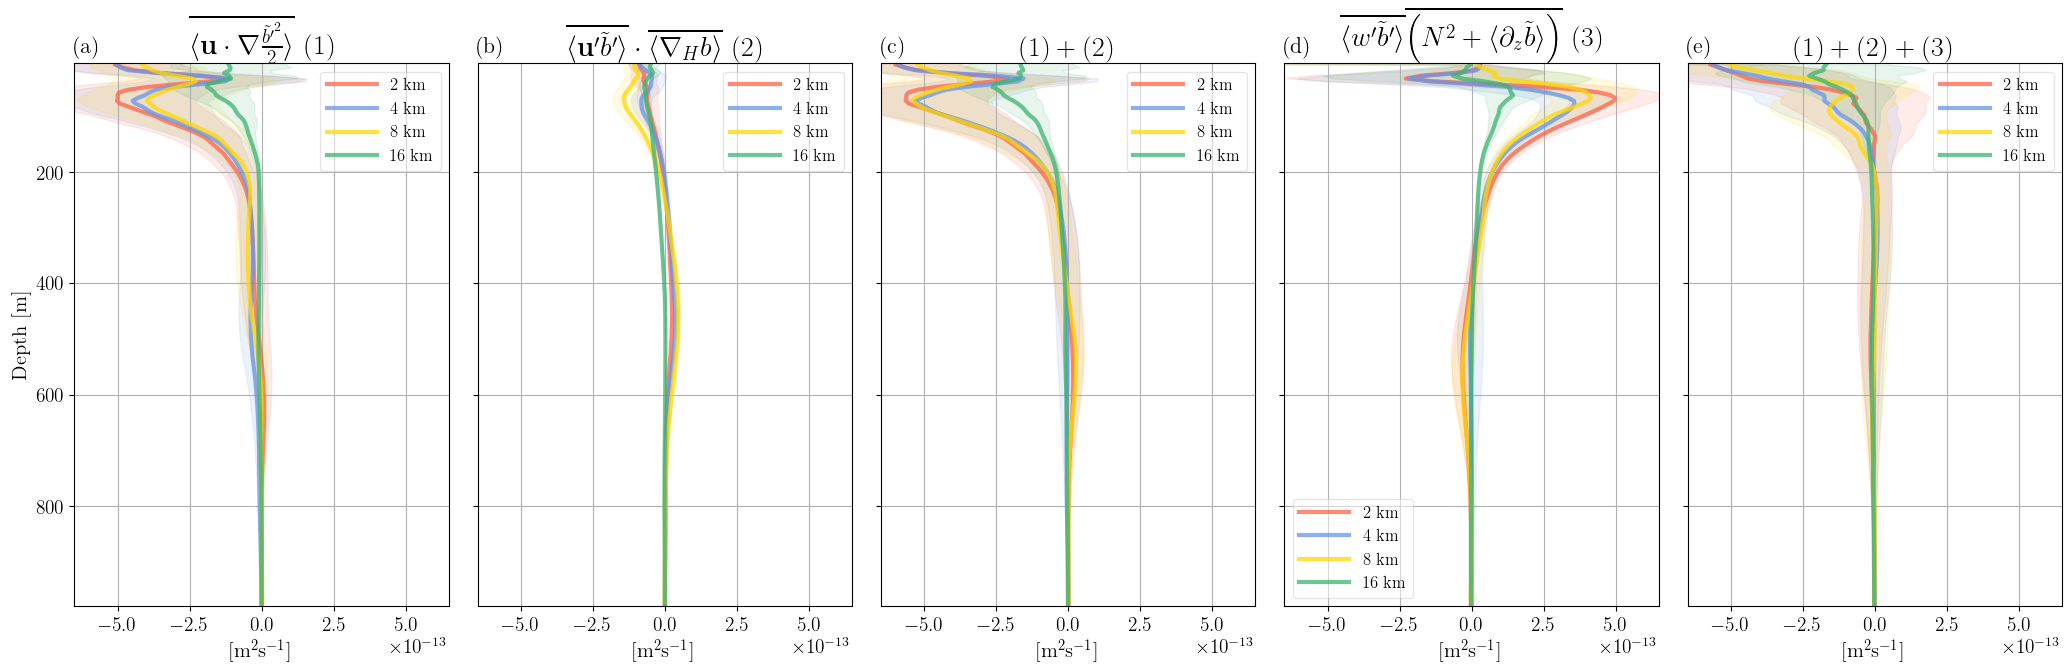

In [22]:
terms = ['wpbp', 'wpbpbtilde_z','Upbpdotgradb',
         'Udotgradbp2', 'Udotgradbp2_h']

titles = [r"$\overline{\langle \mathbf{u} \cdot \nabla \frac{\tilde {b'}^2}{2} \rangle} $  $\mathrm{(1)}$", 
          r"$\overline{\langle \mathbf{u}' {\tilde b'} \rangle} \cdot \overline{\langle \nabla_H b \rangle}$  $\mathrm{(2)}$", 
          r"$\mathrm{(1)+(2)}$", 
          r"$\overline{\langle w' {\tilde b'} \rangle} \overline{\left( N^2 + \langle \partial_z \tilde b \rangle \right)}$  $\mathrm{(3)}$", 
          r"$\mathrm{(1)+(2)+(3)}$",          
         ]
axtexts = [r'$\mathrm{(a)}$',r'$\mathrm{(b)}$',r'$\mathrm{(c)}$',r'$\mathrm{(d)}$',r'$\mathrm{(e)}$']

fig = plt.figure(figsize=(21,7), dpi=100, tight_layout=True)

plt.subplot(1,5,1)
for r in res:
    plt.plot(((mean_std[r]['Udotgradbp2_m'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].Udotgradbp2_m+mean_std[r].Udotgradbp2_s/(4), 
                      mean_std[r].Udotgradbp2_m-mean_std[r].Udotgradbp2_s/(4), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'])
plt.ylabel(r'$\mathrm{Depth}$ $[\mathrm{m}]$', fontsize=15)
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[0], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[0]);

plt.subplot(1,5,2)
for r in res:
    plt.plot(((mean_std[r]['Upbpdotgradb_m'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].Upbpdotgradb_m+mean_std[r].Upbpdotgradb_s/(4), 
                      mean_std[r].Upbpdotgradb_m-mean_std[r].Upbpdotgradb_s/(4), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [])
plt.ylabel('')
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[1], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[1]);

plt.subplot(1,5,3)
for r in res:
    plt.plot(((mean_std[r]['P12_m'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].P12_m+mean_std[r].P12_s/(4), 
                      mean_std[r].P12_m-mean_std[r].P12_s/(4), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [])
plt.ylabel('')
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[2], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[2]);

plt.subplot(1,5,4)
for r in res:
    plt.plot(((mean_std[r]['P3_m'])).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].P3_m+mean_std[r].P3_s/(4), 
                      mean_std[r].P3_m-mean_std[r].P3_s/(4), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [])
plt.ylabel('')
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[3], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[3]);

plt.subplot(1,5,5)
for r in res:
    plt.plot(((mean_std[r]['P123_m'])).sel(Z=slice(-5,-1000)), 
             mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r], alpha=0.75)
    plt.fill_betweenx(mean_std[r].Z, 
                      mean_std[r].P123_m+mean_std[r].P123_s/(4), 
                      mean_std[r].P123_m-mean_std[r].P123_s/(4), color = colours[r], alpha=0.12)
    
plt.ylim([-980,-5])
plt.xlim([-6.5e-13,6.5e-13])
plt.yticks([-200,-400,-600,-800], [])
plt.ylabel('')
plt.xlabel(r'$[\mathrm{m^2s^{-1}}]$', fontsize=15)
plt.title(titles[4], fontsize=20)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()
plt.text(-6.51e-13,15, axtexts[4]);
# fig.savefig(figdir + 'PE_budget_terms_unnormalized')
# fig.savefig(figdir + 'PE_budget_terms_unnormalized.pdf', dpi=200)

/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


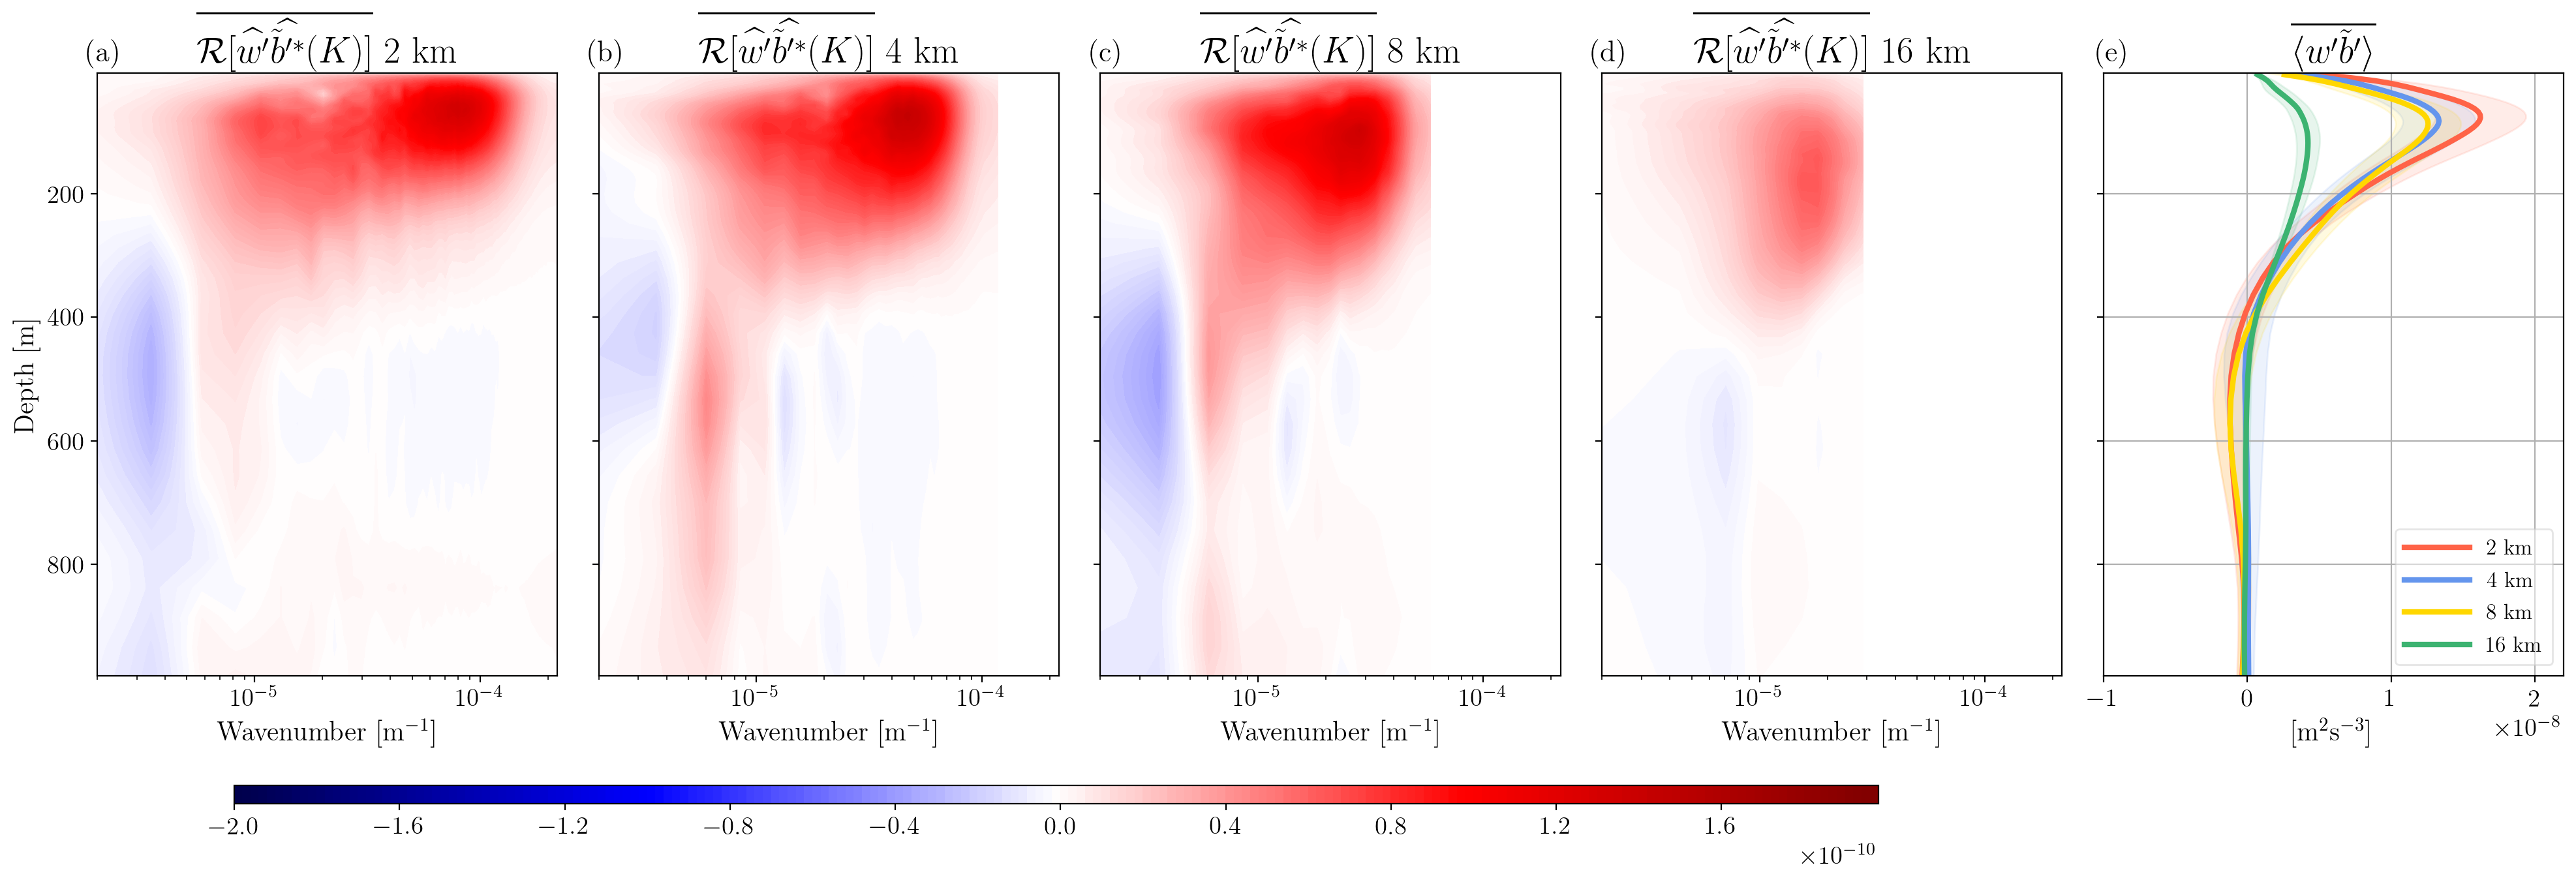

In [27]:
fig, axes = plt.subplots(ncols=5, figsize=(21,7), constrained_layout=True, dpi=200)
axtexts = [r'$\mathrm{(a)}$',r'$\mathrm{(b)}$',r'$\mathrm{(c)}$',r'$\mathrm{(d)}$',r'$\mathrm{(e)}$']
for i, r in enumerate(res):
    im0 = (wphbph[r]*wphbph[r].freq_r)[:,1:].plot.contourf(ax = axes[i], cmap='seismic', levels = np.arange(-2,2,2e-2)*1e-10, add_labels=False, add_colorbar=False)
    axes[i].set_xscale('log')
    axes[i].set_xlim([2e-6,2.2e-4])
    axes[i].set_ylim([-980,-5])
    
    axes[i].set_xlabel(r'$\mathrm{Wavenumber}$ $[\mathrm{m^{-1}}]$', fontsize=15)
    if (r=='2km'):
        axes[i].set_ylabel(r'$\mathrm{Depth}$ $[\mathrm{m}]$', fontsize=15)
        axes[i].set_yticks([-200,-400,-600,-800])
        axes[i].set_yticklabels([r'$200$',r'$400$',r'$600$',r'$800$'])
    else:
        axes[i].set_ylabel('')
        axes[i].set_yticks([-200,-400,-600,-800])
        axes[i].set_yticklabels([])
    axes[i].set_title(r"$\overline{\mathcal{R}[\widehat{w'} \widehat{\tilde b'^*} (K)]}$ " + labels[r])
#     axes[i].set_title(r'$\overline{w^{\prime} b^{\prime}}$, ' + labels[r])
    axes[i].text(1.8e-6, 15, axtexts[i])
fig.subplots_adjust(bottom=0.22, top= 0.88, left=0.05, right=0.95, wspace=0.09, hspace=0.35)

cax = plt.axes([0.1, 0.08, 0.6, 0.02])

cbar = fig.colorbar(im0, cax = cax, orientation='horizontal', extend='both')#, ticks = [-2,-1.5, 1, 0.5, 1, 1.5, 2])

for r in res:
    axes[4].plot((mean_std[r]['wpbp_m']).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
    axes[4].fill_betweenx(mean_std[r].Z, 
                      mean_std[r].wpbp_m+mean_std[r].wpbp_s/(5), 
                      mean_std[r].wpbp_m-mean_std[r].wpbp_s/(5), color = colours[r], alpha=0.12)
    
axes[4].set_ylim([-980,-5])
axes[4].set_xlim([-1e-8,2.2e-8])
axes[4].set_yticks([-200,-400,-600,-800])
axes[4].set_yticklabels([])
axes[4].set_ylabel('')
axes[4].set_xlabel(r'$[\mathrm{m^2s^{-3}}]$', fontsize=15)
axes[4].set_title(r"$\overline{\langle w' \tilde b' \rangle}$", fontsize=20)
axes[4].legend(fontsize=12, loc=0, framealpha=0.5)
axes[4].grid()
# axes[4].set_aspect(aspect=1)
axes[4].text(-1.05e-8, 15, axtexts[-1]);


fig.savefig(figdir + 'wpbtildep')
fig.savefig(figdir + 'wpbtildep.pdf', dpi=200)

/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


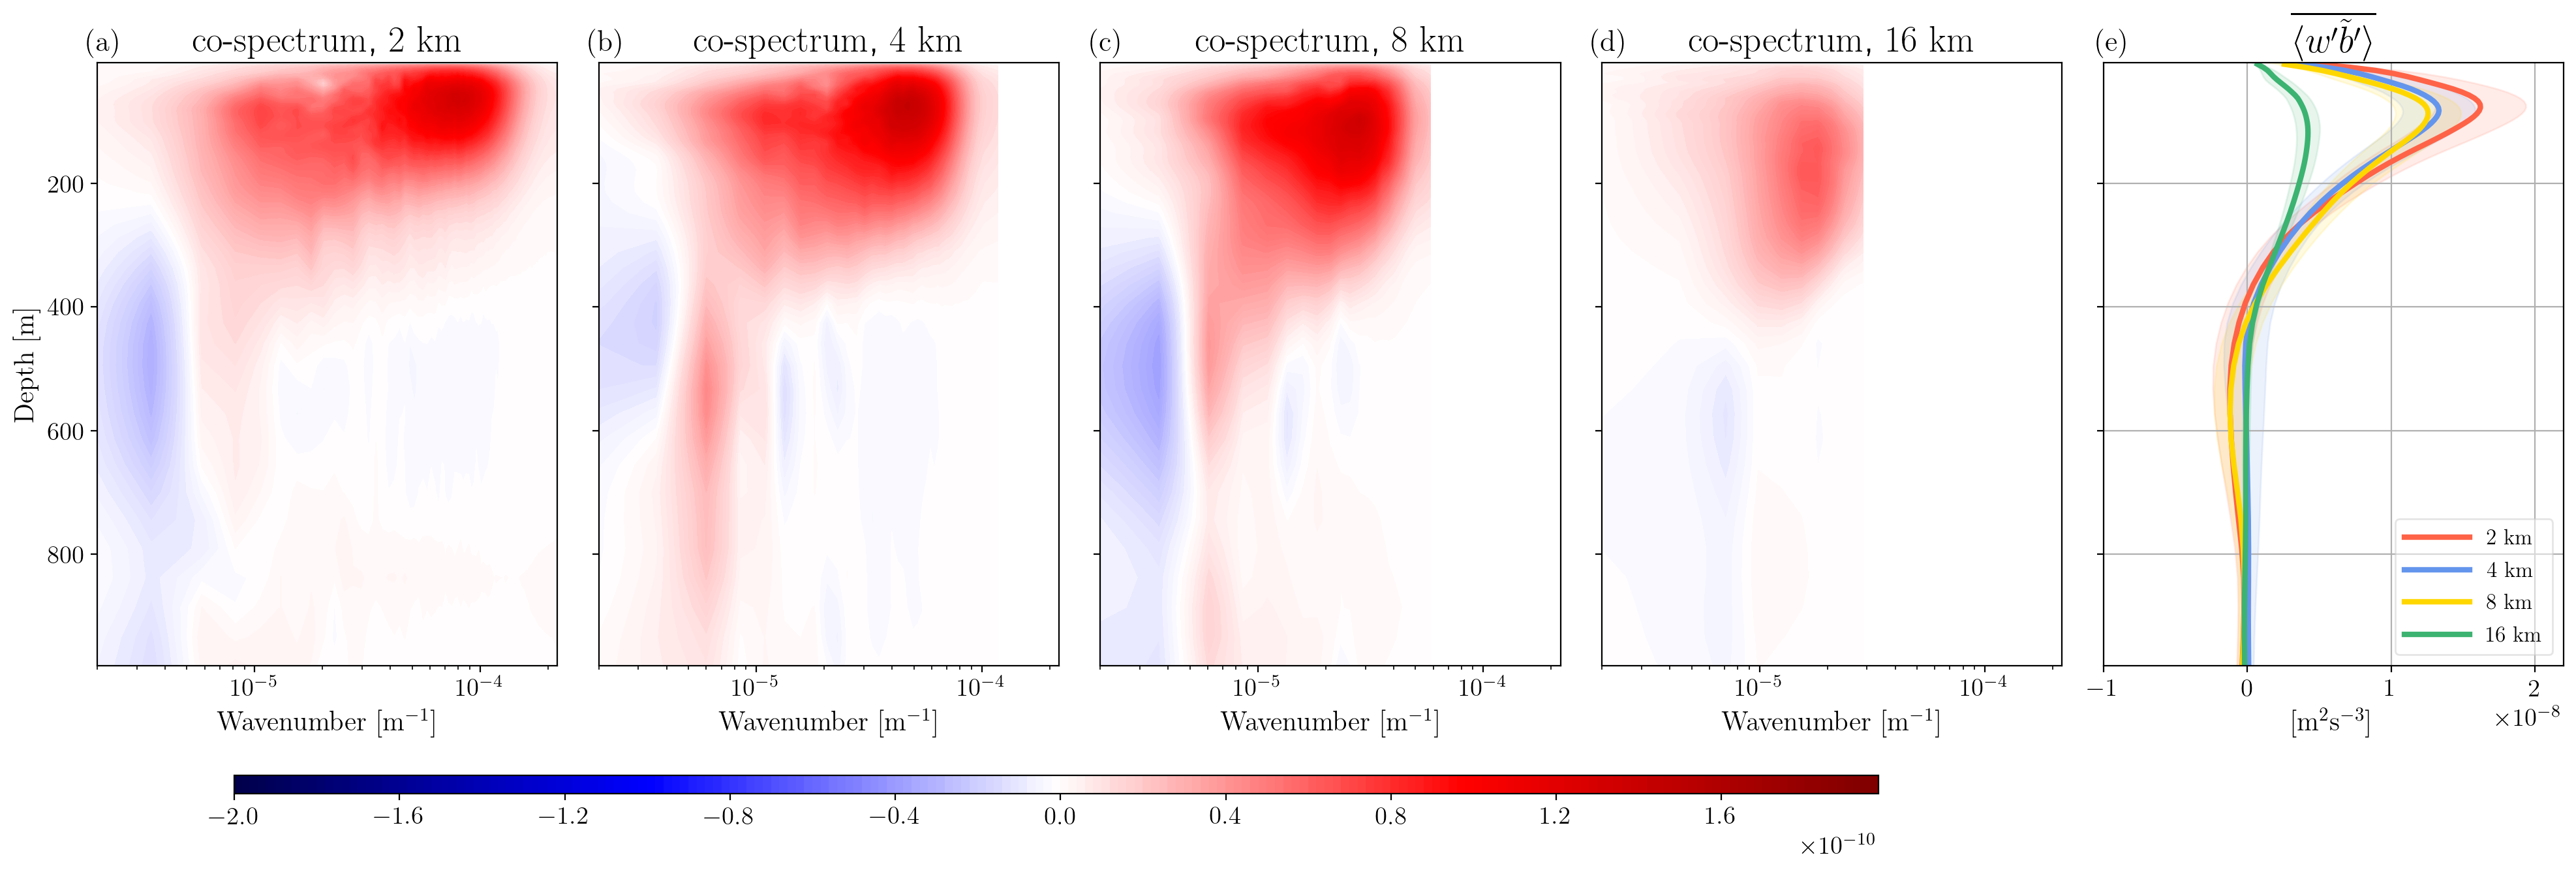

In [73]:
fig, axes = plt.subplots(ncols=5, figsize=(21,7), constrained_layout=True, dpi=200)
axtexts = [r'$\mathrm{(a)}$',r'$\mathrm{(b)}$',r'$\mathrm{(c)}$',r'$\mathrm{(d)}$',r'$\mathrm{(e)}$']
for i, r in enumerate(res):
    im0 = (wphbph[r]*wphbph[r].freq_r)[:,1:].plot.contourf(ax = axes[i], cmap='seismic', levels = np.arange(-2,2,2e-2)*1e-10, add_labels=False, add_colorbar=False)
    axes[i].set_xscale('log')
    axes[i].set_xlim([2e-6,2.2e-4])
    axes[i].set_ylim([-980,-5])
    
    axes[i].set_xlabel(r'$\mathrm{Wavenumber}$ $[\mathrm{m^{-1}}]$', fontsize=15)
    if (r=='2km'):
        axes[i].set_ylabel(r'$\mathrm{Depth}$ $[\mathrm{m}]$', fontsize=15)
        axes[i].set_yticks([-200,-400,-600,-800])
        axes[i].set_yticklabels([r'$200$',r'$400$',r'$600$',r'$800$'])
    else:
        axes[i].set_ylabel('')
        axes[i].set_yticks([-200,-400,-600,-800])
        axes[i].set_yticklabels([])
    axes[i].set_title(r"$\mathrm{co}$-$\mathrm{spectrum}$, " + labels[r])
#     axes[i].set_title(r'$\overline{w^{\prime} b^{\prime}}$, ' + labels[r])
    axes[i].text(1.8e-6, 15, axtexts[i])
fig.subplots_adjust(bottom=0.22, top= 0.88, left=0.05, right=0.95, wspace=0.09, hspace=0.35)

cax = plt.axes([0.1, 0.08, 0.6, 0.02])

cbar = fig.colorbar(im0, cax = cax, orientation='horizontal', extend='both')#, ticks = [-2,-1.5, 1, 0.5, 1, 1.5, 2])

for r in res:
    axes[4].plot((mean_std[r]['wpbp_m']).sel(Z=slice(-5,-1000)), mean_std[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
    axes[4].fill_betweenx(mean_std[r].Z, 
                      mean_std[r].wpbp_m+mean_std[r].wpbp_s/(5), 
                      mean_std[r].wpbp_m-mean_std[r].wpbp_s/(5), color = colours[r], alpha=0.12)
    
axes[4].set_ylim([-980,-5])
axes[4].set_xlim([-1e-8,2.2e-8])
axes[4].set_yticks([-200,-400,-600,-800])
axes[4].set_yticklabels([])
axes[4].set_ylabel('')
axes[4].set_xlabel(r'$[\mathrm{m^2s^{-3}}]$', fontsize=15)
axes[4].set_title(r"$\overline{\langle w' \tilde b' \rangle}$", fontsize=20)
axes[4].legend(fontsize=12, loc=0, framealpha=0.5)
axes[4].grid()
# axes[4].set_aspect(aspect=1)
axes[4].text(-1.05e-8, 15, axtexts[-1]);


fig.savefig(figdir + 'wpbtildep')
fig.savefig(figdir + 'wpbtildep.pdf', dpi=200)

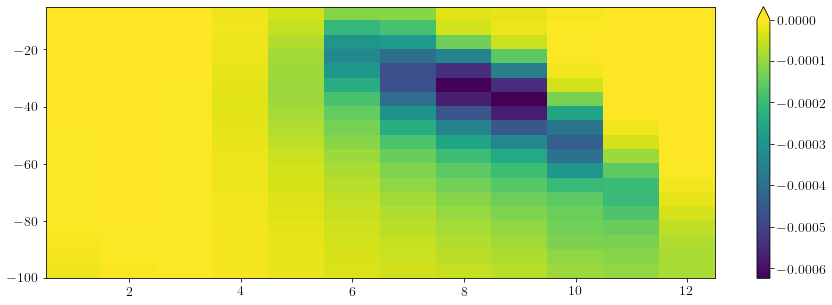

In [64]:
ds_b['2km'].b_z.groupby('time.month').mean(dim='time').sel(Z=slice(-5,-100)).T.plot(add_labels=False, vmax=0)

In [67]:
(ds_b['2km'].b_z.groupby('time.month').mean(dim='time').sel(Z=slice(-5,-1000), month=slice(1,3)).mean(dim='month')).values

array([-7.67616375e-07, -9.32893317e-07, -1.06754745e-06, -1.25717909e-06,
       -1.47989388e-06, -1.70012382e-06, -1.90313907e-06, -2.07995993e-06,
       -2.21871651e-06, -2.31199826e-06, -2.37177483e-06, -2.41819366e-06,
       -2.47180578e-06, -2.56231949e-06, -2.76855751e-06, -3.28743851e-06,
       -4.36605314e-06, -6.05923100e-06, -8.20347930e-06, -1.05299036e-05,
       -1.26462476e-05, -1.41964107e-05, -1.51268625e-05, -1.56567443e-05,
       -1.60447229e-05, -1.64179362e-05, -1.67231581e-05, -1.67864960e-05,
       -1.64563825e-05, -1.57674265e-05, -1.49263882e-05, -1.41315922e-05,
       -1.35323357e-05, -1.32466579e-05, -1.33059099e-05, -1.36017497e-05,
       -1.38618698e-05, -1.37305587e-05, -1.29908856e-05, -1.18435829e-05,
       -1.11036787e-05, -1.19033654e-05, -1.47995767e-05, -1.91829776e-05,
       -2.35082271e-05, -2.61788724e-05, -2.64787602e-05, -2.46469557e-05,
       -2.11579544e-05, -1.65377969e-05, -1.19554570e-05, -8.55430754e-06,
       -6.76447538e-06, -